## Introduction

The 2017 Las Vegas shooting, the deadliest mass shooting committed by an individual in the United States occurring on the night of Sunday, October 1, 2017 again brought public attention back to gun violence. As the graduate students in the United States, we want to analysis the data of gun violence occurring in the last few years and get some information concerning generally the severity, distribution and time series properties of shoots. 

In [1]:
import numpy as np
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup, element

import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

import imageio
from mpl_toolkits.basemap import Basemap

D:\Users\lxy2015\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Content
In the project, we collect gun violence data using our own scraper and download some related csv files on the Internet to help us do the comprehensive analysis. Basically, the report will focus on the following four parts. We first introduce our way to collect data. And then we provide intuitive visualizations upon the data gathered. Next, we do time series analysis based on a few columns. Finally, we convey our message over the whole project.
- [1.Data Collection](#1.-Data-Collection)
- [2.General Visualization](#2.-General-Visualization)
- [3.Time Series Analysis](#3.-Time-Series-Analysis)
- [4.Epilogue](#4.-Epilogue)

## 1. Data Collection

We have multiple data sources. Some of them are in the format of web pages and others are directly accessible csv files. The following are the methods and corresponding formats for our data sources.
* Scraping http://www.gunviolencearchive.org/ for gun violences from 2014/01 to 2018/04
* Csv file of personal income in the United States in 2016 by state (https://www.statista.com/statistics/303512/us-personal-income-by-state/)
* Csv file of number of registered weapons in the U.S. in 2017 by state (https://www.statista.com/statistics/215655/number-of-registered-weapons-in-the-us-by-state/)
* Csv file of public views on gun control from 2014 to 2017 (http://www.people-press.org/2017/06/22/public-views-about-guns)

### 1.1 Parse the web page and extract gun violences

Gun Violence Archive (http://www.gunviolencearchive.org/) is a not for profit corporation formed in 2013 to provide free online public access to accurate information about gun-related violence in the United States. GVA will collect and check for accuracy, comprehensive information about gun-related violence in the U.S. and then post and disseminate it online.

As is in the assignment, we use `BeautifulSoup` to parse the content get all the shoots occurring from 2014/01 to 2018/04.

In [2]:
# For collecting geo information of a shoot, we have to define a function going down a level deeper
# because of the structure of their web page.
def extract_geoinfo(url):
    r = requests.get(url)
    root = BeautifulSoup(r.content, "html.parser")
    pattern = re.compile(r'Geolocation.*')
    all_spans = root.find_all('span',text=pattern)
    latlon = all_spans[0].get_text().split(':')[-1]
    lat = latlon.split(',')[0].strip()
    lon = latlon.split(',')[1].strip()
    return (lat,lon)
extract_geoinfo('http://www.gunviolencearchive.org/incident/274849') # test

('37.2155', '-93.2952')

In [3]:
# All the shoots are distributed in different pages, we have to first define a function which collects
# the data in a single page
base_url = 'http://www.gunviolencearchive.org'
def extract_events_on_single_page(url):
    ret = []
    r = requests.get(url)
    root = BeautifulSoup(r.content, "html.parser")
    all_events = root.find_all('tbody')[0]
    events = all_events.children
    for evt in events:
        if isinstance(evt,element.NavigableString):
            continue
        tds = list(evt.children)
        dt = tds[0].get_text()
        state = tds[1].get_text()
        city = tds[2].get_text()
        n_killed = tds[4].get_text()
        n_injured = tds[5].get_text()
        geo_link = tds[6].find('a').get('href')
        lat, lon = extract_geoinfo(base_url + geo_link)
        row = [dt, state, city, n_killed, n_injured, lat, lon]
        ret.append(row)
    return ret
data_2014_first = extract_events_on_single_page('http://www.gunviolencearchive.org/reports/total-number-of-incidents?year=2014') # test
print(len(data_2014_first))

25


In [4]:
# Different years have diffent starting url, define a function to extract all the shoots in a year.
# The function iteratively calls extract_events_on_single_page() function until no page is remaining.
def extract_year(url):
    ret = []
    row = extract_events_on_single_page(url)
    ret.extend(row)
    r = requests.get(url)
    root = BeautifulSoup(r.content, "html.parser")
    next_link = root.find_all('li',class_='pager-next')
    while len(next_link) != 0:
        next_url = 'http://www.gunviolencearchive.org' + next_link[0].find('a').get('href')
        row = extract_events_on_single_page(next_url)
        ret.extend(row)
        r = requests.get(next_url)
        root = BeautifulSoup(r.content, "html.parser")
        next_link = root.find_all('li',class_='pager-next')
    return ret
# test
data_2014 = extract_year('http://www.gunviolencearchive.org/reports/total-number-of-incidents?page=0&year=2014')
print(len(data_2014))

450


In [5]:
# Finally, we iteratively crawl all the data from 2014 to 2018 and generate a dataframe
def extract_all():
    ret = []
    for i in range(2014, 2019):
        yearstr = str(i)
        data_year = extract_year('http://www.gunviolencearchive.org/reports/total-number-of-incidents?page=0&year='+yearstr)
        ret.extend(data_year)
    return ret
data_all = extract_all()
t_df = pd.DataFrame(data_all, columns=['date','state','city','n_killed','n_injured','lat','lon'])
t_df.head()

,date,state,city,n_killed,n_injured,lat,lon
0,"December 31, 2014",Missouri,Springfield,0,1,37.2155,-93.2952
1,"December 31, 2014",Maryland,Baltimore,0,1,39.3234,-76.5568
2,"December 31, 2014",Maryland,Baltimore,0,1,39.3537,-76.5605
3,"December 31, 2014",Illinois,Chicago,0,1,41.7376,-87.6537
4,"December 31, 2014",Michigan,Ypsilanti,0,0,42.241,-83.6246


### 1.2 process csv files

All the csv files we downloaded will be used in the following and we should do some simple processing now.

In [ ]:
df = pd.read_csv("income_2017_by_state.csv")
# print(df)
income = {}
for index, row in df.iterrows():
    income[row['State']] = int(pd.to_numeric(row['Income'].replace(',','')))
print(income)

In [ ]:
df = pd.read_csv("resident_population_2017_by_state.csv")
population = {}
for index, row in df.iterrows():
    population[row['state']] = pd.to_numeric(row['residents'])
print(population)

In [ ]:
df = pd.read_csv("weapons_registered_2017_by_state.csv")
weapons = {}
for index, row in df.iterrows():
    weapons[row['state']] = pd.to_numeric(row['registered_weapons'].replace(',',''))
print(weapons)

In [ ]:
df = pd.read_csv("Trump_election_by_state.csv")
advocacy = {}
for index, row in df.iterrows():
    advocacy[row['state']] = row['share_of_eligible_voters']
print(advocacy)

## 2. General Visualization

In this section, we process the dataframe generated above to provide intuitive visualization including:
* Top 10 Most Severe Shoots in recent years
* Series of picture show the gun violence distribution
* Relationship between state features and gun violence distribution

### 2.1 Display Top 10 Most Severe Shoots
In this section we process the data and show the top 10 most severe shoots in the last five years.

In [63]:
# process the data
df = pd.read_csv("gun-violence-data.csv")
df["victim_count"] = df["n_killed"] + df["n_injured"]
df.sort_values(['victim_count','n_killed'],ascending=[0,0],inplace=True)
df = df[['n_killed','n_injured','state','city_or_county','date']]
df.head()

,n_killed,n_injured,state,city_or_county,date
130448,50,53,Florida,Orlando,2016-06-12
217151,27,20,Texas,Sutherland Springs,2017-11-05
101531,16,19,California,San Bernardino,2015-12-02
232745,17,17,Florida,Pompano Beach (Parkland),2018-02-14
70511,9,18,Texas,Waco,2015-05-17


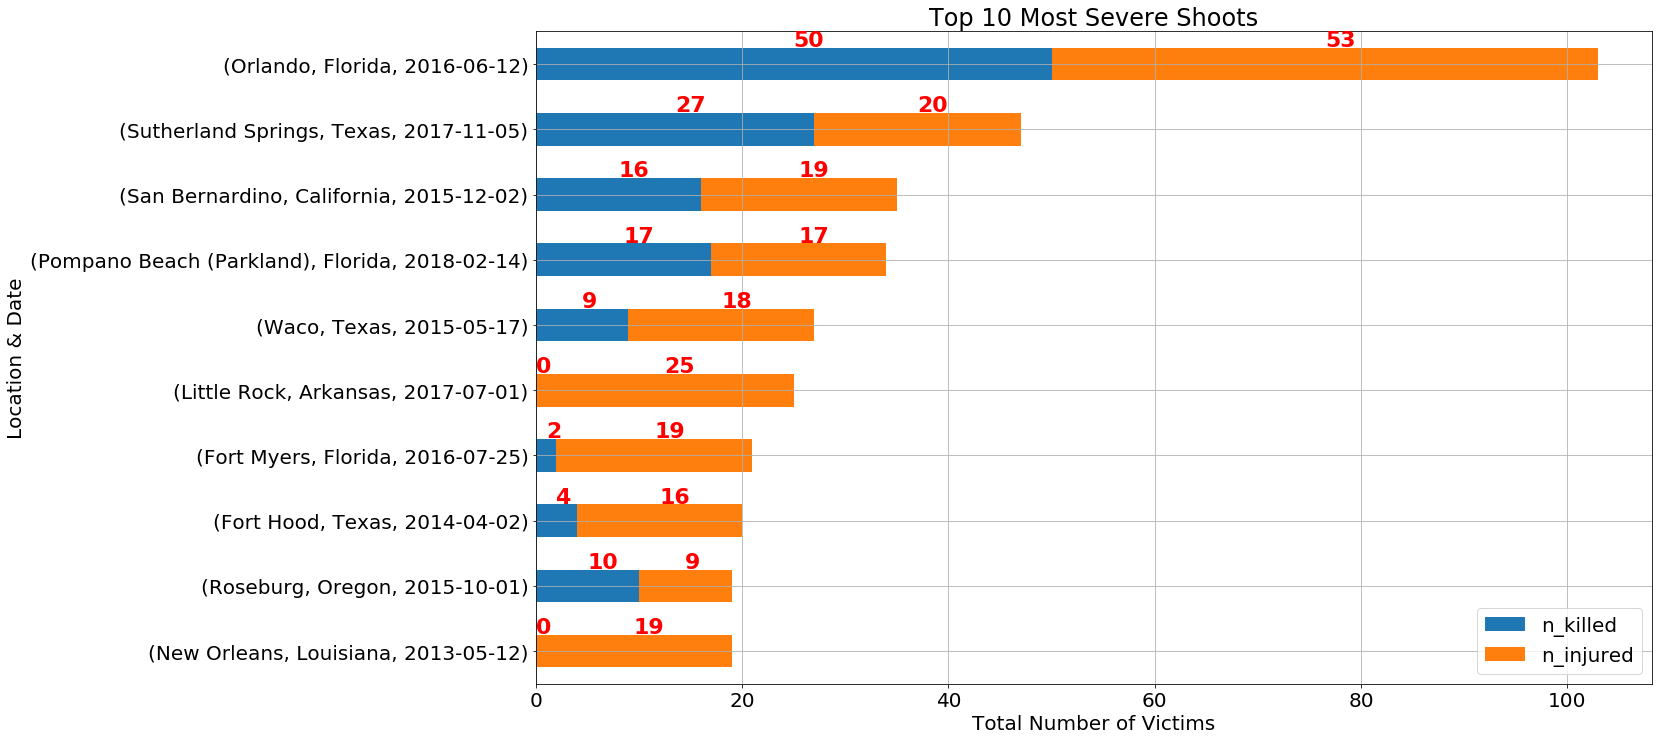

In [70]:
# Display the top 10 most severe shoots with bar plot.
pdf = df.head(10).iloc[::-1]
notes = [k for (k,i) in zip(pdf['n_killed'],pdf['n_injured'])]
notes += [i for (k,i) in zip(pdf['n_killed'],pdf['n_injured'])]
barh = pdf.plot.barh(x=['city_or_county','state','date'],
                    y=['n_killed','n_injured'],
                    grid=True,
                    fontsize=20,
                    stacked=True,
                    figsize=(20,12))
plt.xlabel('Total Number of Victims', fontsize=20)
plt.ylabel('Location & Date', fontsize=20)
plt.title('Top 10 Most Severe Shoots', fontsize=24)
i = 0
for rect in barh.patches:
    barh.text(rect.get_x()+rect.get_width()/2, 
              rect.get_y()+rect.get_height()*1.05,
              str(notes[i]), 
              fontsize=22,
              fontweight="bold",
              color='red')
    i += 1
plt.legend(prop={'size':20})
fig = barh.get_figure()
# fig.savefig('Top_10_Most_Severe_Shoots.png',dpi=300,bbox_inches = 'tight')

Each bar represents a shoot and they are sorted by the number of deaths and injuries. Numbers marked over a bar show the corresponding number for people killed and injured.

### 2.2 Series of picture show the gun violence distribution

Now we begin to draw a series of picture that show gun shoot before a series of time.

First, we generate the filter for each time period and use this to filt the original dataset and get a series of sub-dataset. When drawing each figure, we concatenate the data from new time period to the previous dataset and then using this dataset to draw the figure.

The library we use to draw the picture is the basemap package from matplotlib. Basemap is a great tool for creating maps using python in a simple way. It’s a matplotlib extension, so it has got all its features to create data visualizations, and adds the geographical projections and some datasets to be able to plot coast lines, countries, and so on directly from the library. 

After the generation of each figure, we save it to a .png file. By displaying the series of picture, we can clearly see the increasing of gun violence from 2013 to 2017. In the picture, each red point representing a single gun violence incident. We draw this point with an alpha argument which make the point transparent. This can help us figure out where did gun violence happened more frequently: some place have many clear, big, deep red points and other only have blurred, sporadic dots.

From the series of picture, we can not only get the information of the number and frequency of gun violence, but only the distribution of it. The western coast and eastern coast have more gun violence incidents, partly because the population density of these place are higher than others. The gun violence in middle area is significantly less than other area.

In [3]:
# Sample it down to only the North America region 
lon_min, lon_max = -132.714844, -59.589844
lat_min, lat_max = 13.976715,56.395664

def plot_shooting_figure(df):
    #initiate the figure
    plt.figure(figsize=(20,10))
    image = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')

    ax = plt.gca()
    ax.get_axis_bgcolor = ax.get_facecolor
    image.fillcontinents(color='#FFFFFF',lake_color='#A1D5E1', ax=ax, alpha=1) 
    image.drawmapboundary(fill_color='#A1D5E1')
    image.drawcountries(linewidth=0.5, color="b")
    image.drawstates(color="#004b66")

    # Plot the data
    mxy = image(df["longitude"].tolist(), df["latitude"].tolist())
    image.scatter(mxy[0], mxy[1], s=5, c="#FF4500", lw=0, alpha=0.5, zorder=5)

    return image

In [4]:
interval_list = []
for year in range(2013, 2019):
    if year != 2018:
        for month in range(1, 13):
            interval_list.append( (year, month) )
    else:
        for month in range(1, 4):
            interval_list.append( (year, month) )

In [ ]:
filter_list = []
for year, month in interval_list:
    filter_list.append( (df['Year'] == year)&(df['Month'] == month) )

In [ ]:
shooting_part_list = []
for index_filter in filter_list:
    shooting_part_list.append(df1[index_filter])

In [ ]:
data = shooting_part_list[0]
for i in range(1, len(shooting_part_list)):
    data = pd.concat([data, shooting_part_list[i]])
    print(len(data))
    image = plot_shooting_figure(data)
    plt.savefig("map_image_"+str(i), dpi=300)

![alt text](http://chuantu.biz/t6/309/1526092172x-1404758234.png "Title")

### 2.3 Relationship between state features and gun violence distribution

We tried to compare the distribution of the gun violence at the scale of states with some features of the states. For example, the total income of the state and the average number of weapon hold by citizens. As a result, we find that no single reason contribute to the distribution. The distribution is caused by more complex reasons and perhaps, it is not properly to analysis this in the whole states. Maybe, by narrow down our analysis unit, we can collect more idea of what makes the distribution of gun violence today.

In [ ]:
# create the map
fig, ax = plt.subplots(figsize=(20,10))
image = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')

# load the shapefile, use the name 'states'
image.readshapefile('st99_d00', name='states', drawbounds=True)

ax = plt.gca()
ax.get_axis_bgcolor = ax.get_facecolor
image.drawcoastlines()
image.fillcontinents(color='#FEFEFE', lake_color='#00AbC6')
image.drawmapboundary(fill_color='#00AbC6')
image.drawcountries(linewidth=0.1, color="b")
colors={}
statenames=[]
cmap = plt.cm.Greens # use 'reversed hot' colormap
vmin = -100; vmax = max(income_dict.values())+200 # set range.
norm = Normalize(vmin=vmin, vmax=vmax)
for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename == "Puerto Rico": continue
    income = income_dict[statename]
    # calling colormap with value between 0 and 1 returns
    # rgba value.  Invert color range (hot colors are high
    # population), take sqrt root to spread out colors more.
    colors[statename] = cmap(np.sqrt((income-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_names = []
for shape_dict in map.states_info:
    state_names.append(shape_dict['NAME'])

ax = plt.gca() # get current axes instance

# get Texas and draw the filled polygon
for state in statenames:
    seg = image.states[state_names.index(state)]
    poly = Polygon(seg, facecolor=colors[state], edgecolor=None, alpha=0.5)
    ax.add_patch(poly)
# Plot the data
mxy = image(data["longitude"].tolist(), data["latitude"].tolist())
image.scatter(mxy[0], mxy[1], s=5, c="#FF4500", lw=0, alpha=0.1, zorder=5)

ax_c = fig.add_axes([0.9, 0.1, 0.03, 0.8])
cb = ColorbarBase(ax_c,cmap=cmap,norm=norm,orientation='vertical',
                  label=r'[income of the whole state in billion]')

plt.show()

![alt text](http://chuantu.biz/t6/309/1526092221x-1404793083.png "Title")

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

# create the map
fig, ax = plt.subplots(figsize=(20,10))
image = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')

# load the shapefile, use the name 'states'
image.readshapefile('st99_d00', name='states', drawbounds=True)

ax = plt.gca()
ax.get_axis_bgcolor = ax.get_facecolor
image.drawcoastlines()
image.fillcontinents(color='#FEFEFE', lake_color='#A1D5E1')
image.drawmapboundary(fill_color='#A1D5E1')
image.drawcountries(linewidth=0.1, color="b")

colors={}
statenames=[]
cmap = plt.cm.Blues # use 'reversed hot' colormap
vmin = min(weapon_dict.values()); vmax = max(weapon_dict.values()) # set range.
norm = Normalize(vmin=vmin, vmax=vmax)
for shapedict in image.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename == "Puerto Rico": continue
    weapon = weapon_dict[statename]
    # calling colormap with value between 0 and 1 returns
    # rgba value.  Invert color range (hot colors are high
    # population), take sqrt root to spread out colors more.
    colors[statename] = cmap(np.sqrt((weapon-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
    
# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_names = []
for shape_dict in image.states_info:
    state_names.append(shape_dict['NAME'])

ax = plt.gca() # get current axes instance

# get Texas and draw the filled polygon
for state in statenames:
    seg = image.states[state_names.index(state)]
    poly = Polygon(seg, facecolor=colors[state], edgecolor=None, alpha=1)
    ax.add_patch(poly)

# Plot the data
mxy = image(df1["longitude"].tolist(), df1["latitude"].tolist())
image.scatter(mxy[0], mxy[1], s=5, c="#FF4500", lw=0, alpha=0.1, zorder=5)

ax_c = fig.add_axes([0.9, 0.1, 0.03, 0.8])
cb = ColorbarBase(ax_c,cmap=cmap,norm=norm,orientation='vertical',
                  label=r'[weapons hold in the state]')

plt.show()

![alt text](http://chuantu.biz/t6/309/1526092253x-1404793083.png "Title")

## 3. Time Series Analysis

In this section, we want to explore and analysis the time series properties of shoots. Specifically, we use `scikit-learn` to help us with the analysis concerning properties like trend, seasonality and predictions as well. This section can be generally divided into the following parts:
* Analyze the number of `victims` by month
* Analyze the number of `shoots` by month
* Predict the number of victims in the near future

### 3.1 Analyze the number of victims by month

In [73]:
# process the data
def read_data(is_monthly, is_victims_total):
    """ 
    Params: 
        is_monthly: (bool) True if monthly grouped data wanted, False if dayly grouped data wanted.
        is_victims_total: (bool) True for counting number of victims, Flase for counting number of shoots. 
    Return:
        df: (DataFrame) Data wanted as Dataframe.
    """
    
    df = pd.read_csv("gun-violence-data.csv")
    df["victim_count"] = df["n_killed"] + df["n_injured"]
    if is_monthly:
        df['date'] = pd.to_datetime(df['date']).apply(lambda dt: dt.replace(day=1))
    else:
        df['date'] = pd.to_datetime(df['date'])
    if is_victims_total:
        df = df[["date", "victim_count"]].groupby(["date"]).sum()
    else:
        df = df.groupby(["date"]).count()
    df.reset_index(inplace=True)
    df = df.loc[df['date'] > datetime.date(2013,12,31)]
    df.reset_index(inplace=True, drop=True)
    return df
df = read_data(True, True)
print(df.dtypes)
df.head()

date            datetime64[ns]
victim_count             int64
dtype: object


,date,victim_count
0,2014-01-01,2945
1,2014-02-01,2068
2,2014-03-01,2558
3,2014-04-01,2761
4,2014-05-01,3199


First, we want to display the original data.

Read data which is grouped by month and summing up "number of killed" and "number of injured" to be the total number of victims.

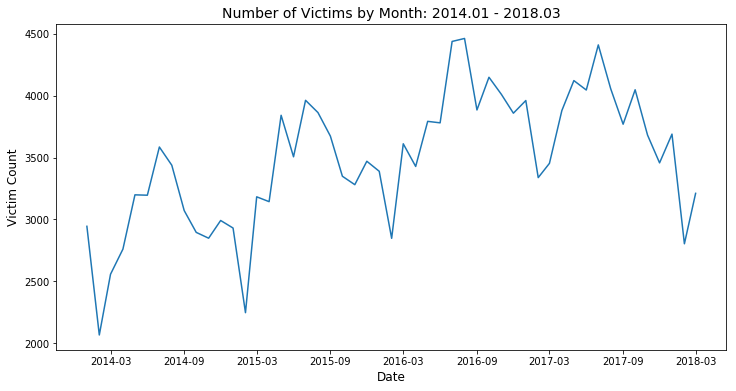

In [74]:
fig = plt.figure(figsize=(12,6))
plt.plot(df['date'], df['victim_count'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Victim Count', fontsize=12)
plt.title('Number of Victims by Month: 2014.01 - 2018.03', fontsize=14)
plt.rcParams["figure.figsize"]=(18,8)
plt.rcParams.update({'font.size':15})
plt.show()
fig.savefig('Victims_by_Month.png',dpi=300)

From the figure above, we can approximately see that the overall victim total is increasing over these years. In order to having a more clear view, in this section let's extract the trend out and show it independently.

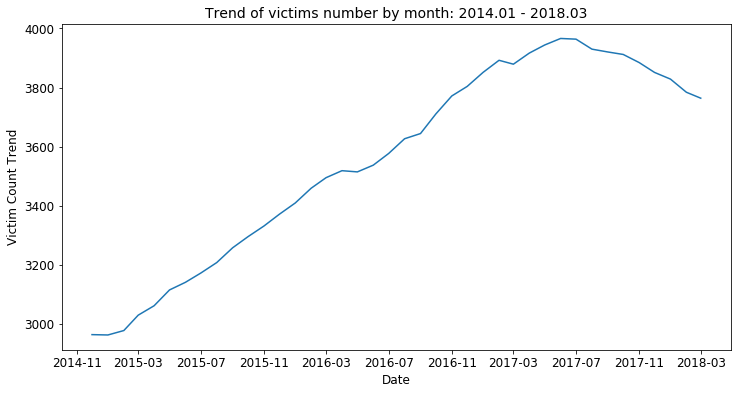

In [77]:
moving_avg = df['victim_count'].rolling(12).mean()
fig = plt.figure(figsize=(12,6))
plt.plot(df['date'], moving_avg)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Victim Count Trend', fontsize=12)
plt.title('Trend of victims number by month: 2014.01 - 2018.03', fontsize=14)
plt.rcParams["figure.figsize"]=(18,8)
plt.rcParams.update({'font.size':12})
plt.show()
fig.savefig('Trend_of_Victims_by_Month.png',dpi=300)

The above figure is the trend extracted from the victim total by month. As we can see, the overall trend keeps increasing to the top at mid of 2017 and now it starts to drop. However, generally speaking the number of victims has increased a lot in these years.

Now let's remove the trend and have a look of if there is any seasonal effect.

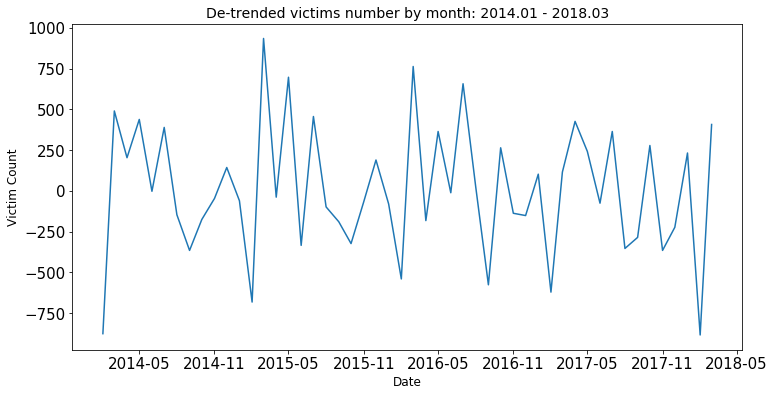

In [80]:
detrended = df['victim_count'].diff()
fig = plt.figure(figsize=(12,6))
plt.plot(df['date'], detrended)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Victim Count', fontsize=12)
plt.title('De-trended victims number by month: 2014.01 - 2018.03', fontsize=14)
plt.rcParams["figure.figsize"]=(18,8)
plt.rcParams.update({'font.size':15})
plt.show()
# fig.savefig('De-trended_Victims_by_Month.png',dpi=300)

From the figure above, we don't think regular seasonality exists in the number of victims. 

Now, we remove seasonality from de-trended data 

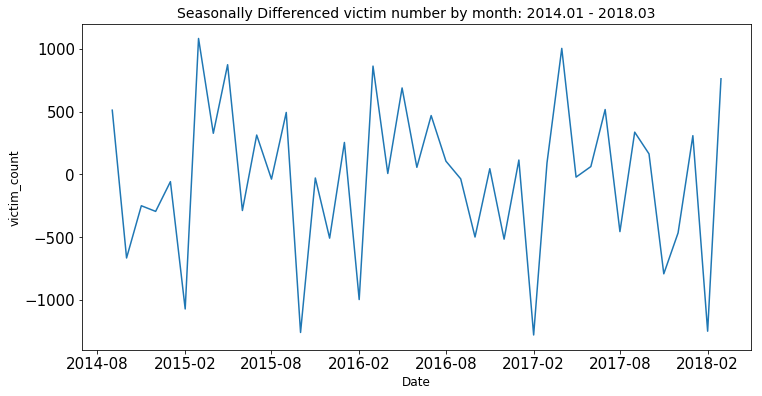

In [82]:
seasonal_diff = detrended.diff(7)
fig = plt.figure(figsize=(12,6))
plt.plot(df['date'], seasonal_diff)
plt.xlabel('Date', fontsize=12)
plt.ylabel('victim_count', fontsize=12)
plt.title('Seasonally Differenced victim number by month: 2014.01 - 2018.03', fontsize=14)
plt.rcParams["figure.figsize"]=(18,8)
plt.rcParams.update({'font.size':15})
plt.show()
# fig.savefig('De-seasoned_Victims_by_Month.png',dpi=300)

### 3.2 Analyze the number of shoots by month

This will be the same process as the above analysis for the number of victims.

In [83]:
df = read_data(True, False)
print(df.dtypes)
df.head()

date                           datetime64[ns]
incident_id                             int64
state                                   int64
city_or_county                          int64
address                                 int64
n_killed                                int64
n_injured                               int64
incident_url                            int64
source_url                              int64
incident_url_fields_missing             int64
congressional_district                  int64
gun_stolen                              int64
gun_type                                int64
incident_characteristics                int64
latitude                                int64
location_description                    int64
longitude                               int64
n_guns_involved                         int64
notes                                   int64
participant_age                         int64
participant_age_group                   int64
participant_gender                

,date,incident_id,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,victim_count
0,2014-01-01,4395,4395,4395,4060,4395,4395,4395,4393,4395,...,3762,3821,1967,43,3902,4112,4370,3772,3873,4395
1,2014-02-01,3045,3045,3045,2754,3045,3045,3045,3044,3045,...,2649,2603,1469,30,2680,2793,3037,2662,2721,3045
2,2014-03-01,3669,3669,3669,3346,3669,3669,3669,3668,3669,...,3211,3146,1804,38,3298,3358,3655,3236,3313,3669
3,2014-04-01,3891,3891,3891,3591,3891,3891,3891,3890,3891,...,3447,3344,1706,34,3487,3524,3851,3378,3458,3891
4,2014-05-01,4320,4320,4320,3924,4320,4320,4320,4319,4320,...,3786,3733,1847,36,3809,3920,4227,3708,3830,4320


First of all, let's count the number of shoot records by month and plot it here.

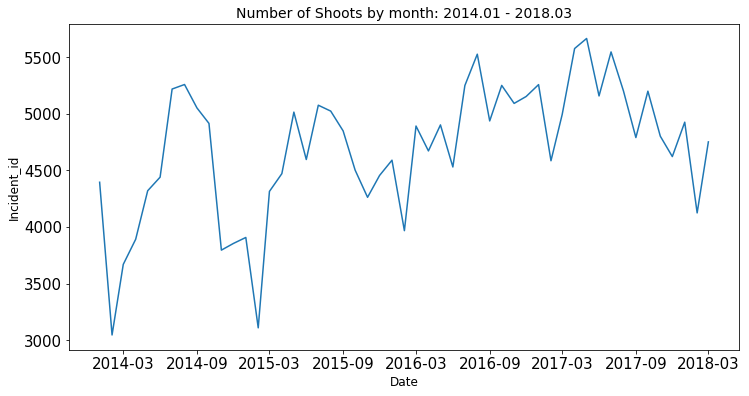

In [86]:
fig = plt.figure(figsize=(12,6))
plt.plot(df['date'], df['incident_id'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Incident_id', fontsize=12)
plt.title('Number of Shoots by month: 2014.01 - 2018.03', fontsize=14)
plt.rcParams["figure.figsize"]=(18,8)
plt.rcParams.update({'font.size':15})
plt.show()
# fig.savefig('Shoots_Number_By_Month.png',dpi=300)

Now like in the previous section, let's plot the trend of the above figure to see it clearly.

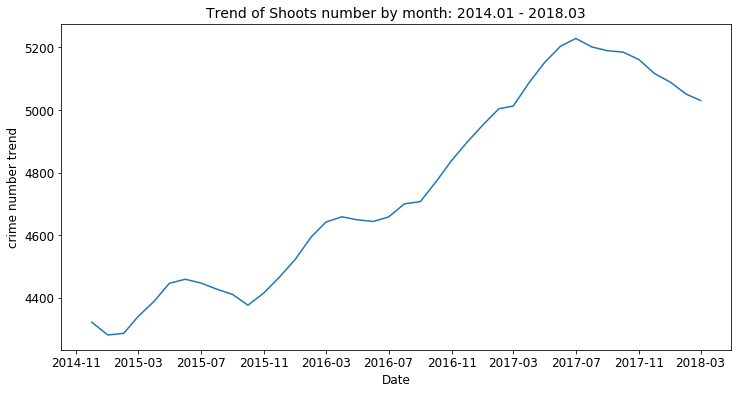

In [89]:
moving_avg = df['incident_id'].rolling(12).mean()
fig = plt.figure(figsize=(12,6))
plt.plot(df['date'], moving_avg)
plt.xlabel('Date', fontsize=12)
plt.ylabel('crime number trend', fontsize=12)
plt.title('Trend of Shoots number by month: 2014.01 - 2018.03', fontsize=14)
plt.rcParams["figure.figsize"]=(18,8)
plt.rcParams.update({'font.size':12})
plt.show()
# fig.savefig('Trend_of_Shoots_Number_by_Month.png',dpi=300)

The trend is similar to that of victims number. Generally speaking the number of victims has increased a lot in these years though the 10 month has a slight decreasing trend.

### 3.3 Predict Future Number of Victims
Since this dataset is a time series data, we further employ ARIMA model to fit current data and make predictions on the future.

Read data again which is grouped by month. Show general information about our ARIMA predictor by fitting the current dataset.

In [92]:
df = read_data(True,True)
df.set_index('date',drop=True,inplace=True)
df['victim_count'] = df['victim_count'].astype(np.float)
print(df.dtypes)
print(df.head())
model = ARIMA(df, order=(5,1,0))
result = model.fit(disp=0)
print(result.summary())

victim_count    float64
dtype: object
            victim_count
date                    
2014-01-01        2945.0
2014-02-01        2068.0
2014-03-01        2558.0
2014-04-01        2761.0
2014-05-01        3199.0
                             ARIMA Model Results                              
Dep. Variable:         D.victim_count   No. Observations:                   50
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -366.978
Method:                       css-mle   S.D. of innovations            371.598
Date:                Fri, 11 May 2018   AIC                            747.956
Time:                        17:51:08   BIC                            761.340
Sample:                    02-01-2014   HQIC                           753.052
                         - 03-01-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

We want to test the predictor performance on existing data.

We first fit the model and predict on the next time point step by step. Specifically, we start with a small partion of the data for fitting the model. Then we use this model to predict number of victims for next month. We record this predicted value and compare it with the true value. Finally we add the true value into the portion of dataset used for model fitting and redo the process.

In [93]:
X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=3962.301651, expected=4148.000000
predicted=4152.659624, expected=4010.000000
predicted=4145.776804, expected=3858.000000
predicted=3928.295076, expected=3960.000000
predicted=4086.149645, expected=3338.000000
predicted=3589.783223, expected=3453.000000
predicted=3409.299608, expected=3879.000000
predicted=3850.982087, expected=4121.000000
predicted=4077.075383, expected=4045.000000
predicted=4116.864467, expected=4409.000000
predicted=4298.128995, expected=4055.000000
predicted=4162.875262, expected=3769.000000
predicted=3824.734576, expected=4047.000000
predicted=4045.188034, expected=3681.000000
predicted=3836.960107, expected=3457.000000
predicted=3629.381597, expected=3689.000000
predicted=3714.021112, expected=2804.000000
predicted=3114.779201, expected=3211.000000
Test MSE: 137699.955


Now let's plot both the true values and the corresponding predictions in the same figure to see basically how well our predictor is.

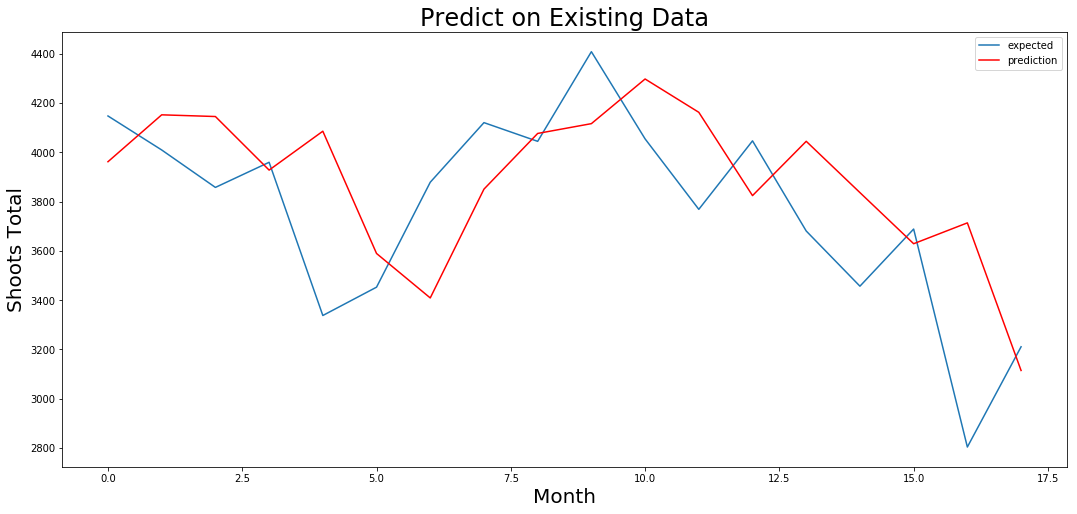

In [95]:
fig = plt.figure()
plt.plot(test, label="expected")
plt.plot(predictions, label="prediction", color='red')
plt.rcParams["figure.figsize"]=(18,8)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Shoots Total', fontsize=20)
plt.title('Predict on Existing Data', fontsize=24)
plt.legend()
plt.show()
# fig.savefig('Predict_on_Existing_Data.png',dpi=300)

From the figure shown above, we can see that our predictor can generally follow the tendency of the real data. Thus we can further use it to depict the universal tendency for next several months.

Here we make a prediction on next 12 months and plot it out. We find that the total number of victims still tend to increase over time, which is certainly not what we want to see happening in the future.

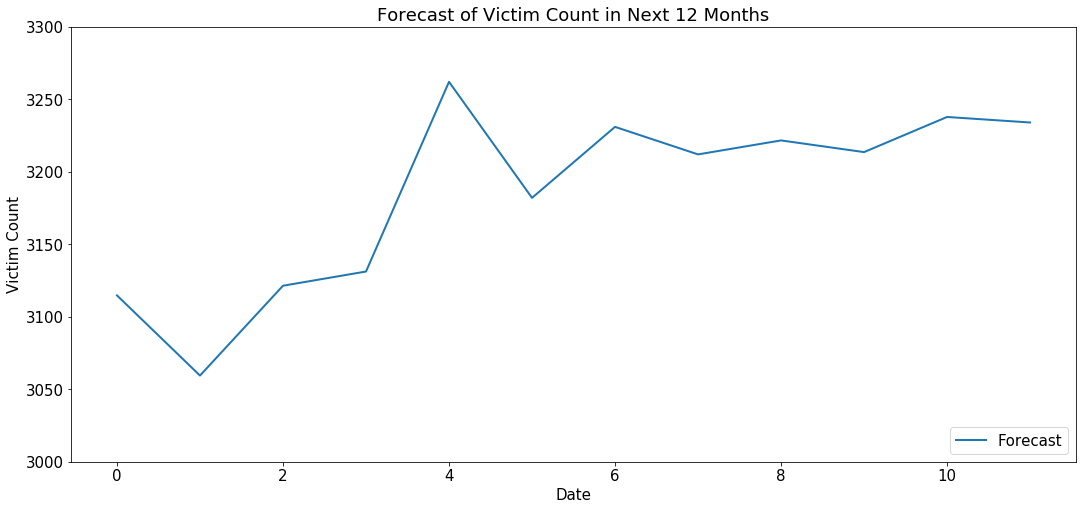

In [97]:
fig = plt.figure()
plt.ylim(3000,3300)
plt.plot(model_fit.forecast(steps=12)[0], linewidth=2.0, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Victim Count')
plt.title("Forecast of Victim Count in Next 12 Months")
plt.legend(loc='lower right')
plt.rcParams["figure.figsize"]=(18,8)
plt.rcParams.update({'font.size':15})
plt.show()
# fig.savefig('Forecast_of_Victims_Next_Year_by_Month.png',dpi=300)

## 4. Epilogue

In this section, we want to convey our message of doing the whole project.

### 4.1 Public views on guns control
From the above analysis, we have seen the increasing trend of the number of guns violence and the serious impact they brought. Then we found a source of data asking people's opinion on guns control from [Pew Research Center](http://www.pewresearch.org/). We suppose there should be an obvious increasing advocacy on controling gun ownership over protecting gun rights.

The data, in the format of csv file, covers public views on guns control from 2013 to 2017. For each time point, two numbers in columns represent percentages for protecting gun rights and controling gun ownership.

We load the data and plot two lines of opposite views in time series.

In [98]:
df = pd.read_csv("public_views.csv", parse_dates=["date"])
df.head()

,date,rights,control
0,2013-01-13,45,51
1,2013-02-18,46,50
2,2013-05-05,48,50
3,2014-02-09,49,48
4,2014-12-07,52,46


Here, we use plot method in matplotlib to plot the figure we want.

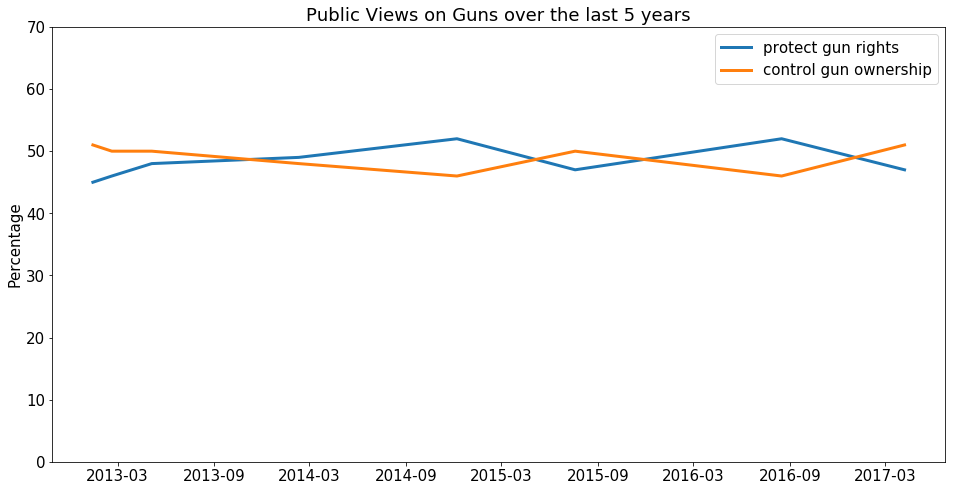

In [100]:
t = df['date']
rights = df['rights']
control = df['control']
fig = plt.figure()
axes = plt.gca()
axes.set_ylim([0,70])
plt.plot(t,rights,label='protect gun rights',linewidth=3.0)
plt.plot(t,control,label='control gun ownership',linewidth=3.0)
plt.ylabel('Percentage')
plt.legend()
fig_size = (16, 8)
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 15})
plt.title('Public Views on Guns over the last 5 years')
plt.show()
# fig.savefig('public_views.png',dpi=300)

To our surprise, as you can see from the above figure, the expected increasing tendency for advocating gun control does not show up while the number of gun violence events keeps increasing from year to year.

### 4.2 Ending

No doubt all citizens want a secure environment for life but we cannot see a promising trend at least from the analysis above. The issue of gun violence is complex and deeply rooted in American culture. We hope that our efforts can bring people with some insights about current shoots situation and arise more attention on gun control.